<a href="https://colab.research.google.com/github/elhamkashi/DSPS_EKashi/blob/main/HW5/fitlinegrbafterglow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

In [54]:
import pandas as pd
import pylab as pl
# you will need more imports, put them here
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

from sklearn.model_selection import train_test_split  #for part 2

HW part 1:



## Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [55]:
# data is called grb050525A.csv in the data folder in the DSPS_FBianco repo
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/refs/heads/main/data/grb050525A.csv")
grbAG.head()


,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


In [56]:
grbAG.shape

(119, 5)

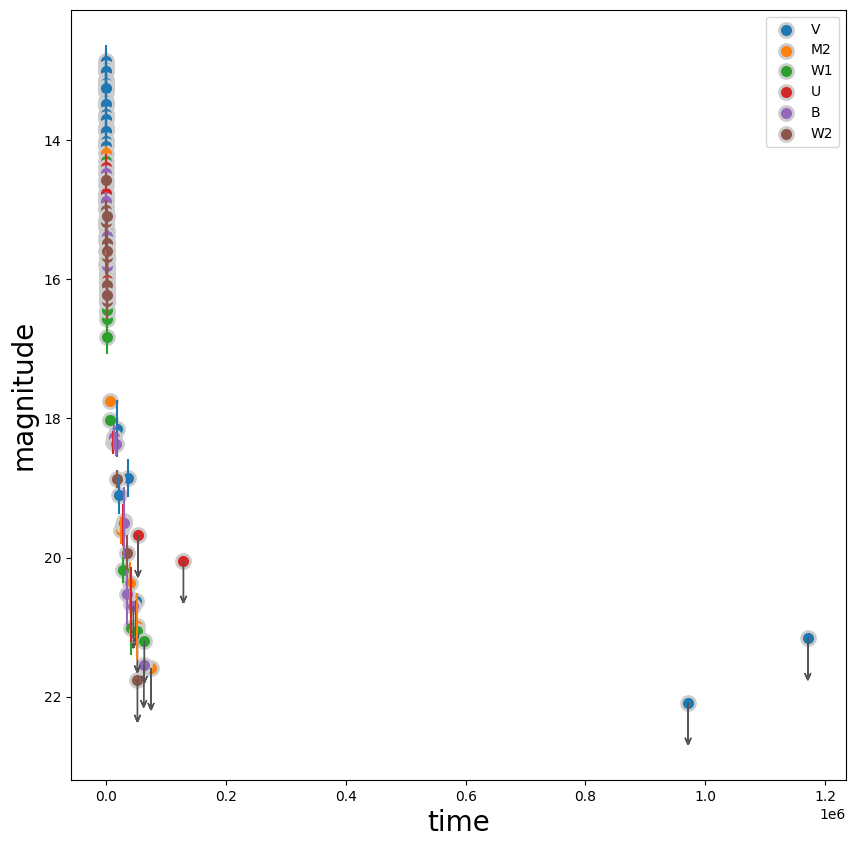

In [57]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
ax.yaxis.set_inverted(True)  # inverted axis with autoscaling
#pl.ylim(24,11.7) #simpler, less elegant - still does the trick
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("time", fontsize=20);

In [58]:


# take log10 of the "time" column and store in a new column "logtime"
grbAG["logtime"] = np.log10(grbAG["time"])

# look at the first few rows
grbAG.head()


,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


## Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

In [59]:
def plotlogtime(df, models=[]):
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows
  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  ax.yaxis.set_inverted(True)  # inverted axis with autoscaling
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time", fontsize=20)
  return ax

<Axes: xlabel='log time', ylabel='magnitude'>

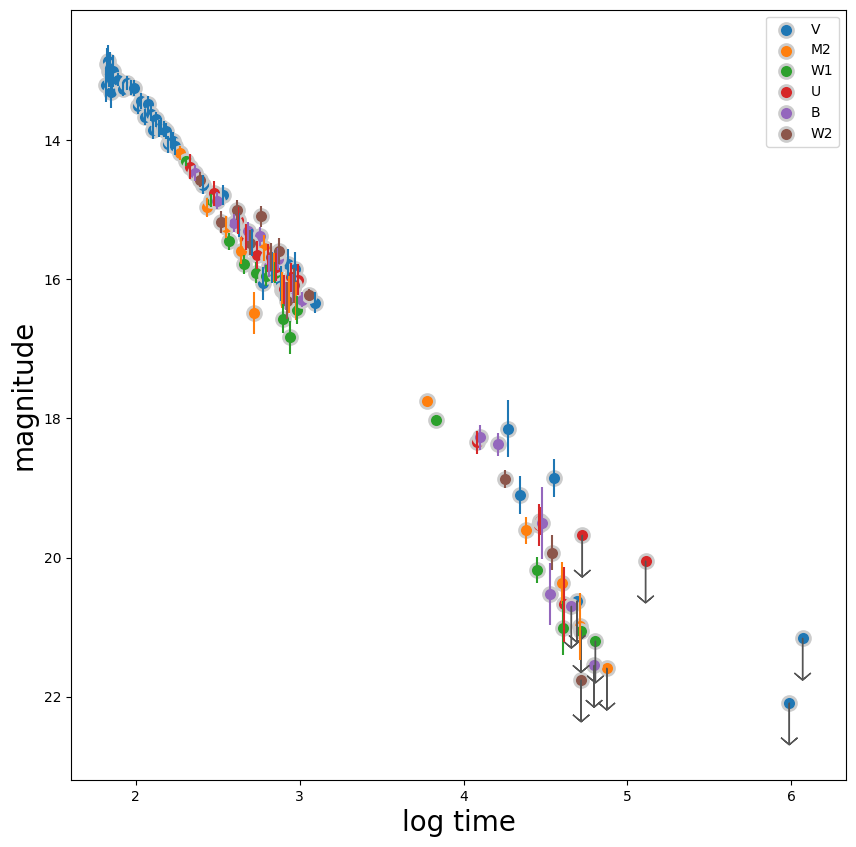

In [60]:
plotlogtime(grbAG)

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

## Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [61]:
# keep only rows where upperlimit == 0 (i.e. real detections)
grbAGnouplim = grbAG[grbAG["upperlimit"] == 0].copy()

# quick check
print(grbAG.shape)        # original number of rows
print(grbAGnouplim.shape) # reduced number of rows


(119, 6)
(108, 6)


In [ ]:
#grbAGnouplim = ...# remove the upper limits from the dataframe to simplify the analysis

In [63]:
x = grbAGnouplim[grbAGnouplim.upperlimit == 0].logtime.values
#pinck a function to expand the axis
#option 1 X = np.c_[np.ones((len(grbAGnouplim), 1)),x]
#option 2 X=np.dstack((np.ones((X.shape[0])) ,x))
X = np.c_[np.ones((len(grbAGnouplim), 1)), x]


y = grbAGnouplim.mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [64]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " +
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


## Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```.
To remove the upper limits you can "broadcast" the data: in pandas that looks like

```grbAG.loc[grbAG.upperlimit == 0]```



In [ ]:
#from original code:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
....

best fit parameters from the sklearn LinearRegression(): intercept 8.58, slope 2.51


In [67]:

# filter out upper limits
clean = grbAG.loc[grbAG.upperlimit == 0]
#grbAG.upperlimit == 0 → Boolean mask (True for detections, False for upper limits)
#.loc[...] → selects only rows where mask is True

# define X (independent variable) and y (dependent variable)
X = clean[["logtime"]]   # note double brackets: sklearn expects a 2D array
y = clean["mag"].values  # 1D array

# initialize and fit the model
lr = LinearRegression()
lr.fit(X, y)

# get best-fit parameters
intercept = lr.intercept_
slope = lr.coef_[0]

print(f"Best fit parameters from sklearn LinearRegression(): intercept = {intercept:.2f}, slope = {slope:.2f}")


Best fit parameters from sklearn LinearRegression(): intercept = 8.58, slope = 2.51


## Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 and L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [68]:
def line(intercept, slope, x):
    return intercept+ slope*x

In [69]:

# model line
def line(intercept, slope, x):
    return intercept + slope * x

# L1 objective function (sum of absolute residuals)
def l1(args, x, y):
    intercept, slope = args
    y_model = line(intercept, slope, x)
    return np.sum(np.abs(y - y_model))

# initial guess for [intercept, slope]
initialGuess = [10, 1]

# minimize the L1 cost
l1Solution = minimize(l1, initialGuess, args=(x, y))

print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "slope {:.2f}, intercept {:.2f}".format(l1Solution.x[1], l1Solution.x[0]))


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 26.303317772383874
        x: [ 8.225e+00  2.641e+00]
      nit: 17
      jac: [-1.359e-01 -2.094e+00]
 hess_inv: [[ 1.935e-04 -4.675e-05]
            [-4.675e-05  1.132e-05]]
     nfev: 391
     njev: 125

best fit parameters from the minimization of L1: slope 2.64, intercept 8.23


In [70]:
def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the endogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    intercept, slope = args
    y_model = line(intercept, slope, x)
    return np.sum((y - y_model)**2)

# initial guess for [intercept, slope]
initialGuess = [10, 1]

# minimize the L2 cost
l2Solution = minimize(l2, initialGuess, args=(x, y))

print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " +
       "slope {:.2f}, intercept {:.2f}".format(l2Solution.x[1], l2Solution.x[0]))


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.82598750072551
        x: [ 8.583e+00  2.512e+00]
      nit: 4
      jac: [ 0.000e+00  2.384e-07]
 hess_inv: [[ 6.254e-02 -2.030e-02]
            [-2.030e-02  7.114e-03]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of L2: slope 2.51, intercept 8.58


In [ ]:
l2?

## Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

##  The χ² (chi-square) objective

To account for uncertainties, you weight residuals by their errors:

**χ²(m, b) = Σ<sub>i</sub> [(y<sub>i</sub> - (m·x<sub>i</sub> + b)) / σ<sub>i</sub>]²**

Where:
- **y<sub>i</sub>** = observed magnitudes
- **m·x<sub>i</sub> + b** = model prediction  
- **σ<sub>i</sub>** = uncertainty (magerr)

So each term is "residual / error" squared.

**Interpretation:**
- If a point has small error, even a small deviation matters → large contribution to χ²
- If a point has large error, its mismatch is down-weighted.

In [71]:


# χ² objective (weights by measurement uncertainties s)
def chi2(args, x, y, s):
    intercept, slope = args
    y_model = intercept + slope * x
    return np.sum(((y - y_model) / s)**2)

# data (detections only — already in grbAGnouplim)
x = grbAGnouplim.logtime.values
y = grbAGnouplim.mag.values
s = grbAGnouplim.magerr.values

# initial guess: [intercept, slope]
initialGuess = [10.0, 1.0]

# minimize χ²
chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")

# report fit (note: solution.x = [intercept, slope])
print("best fit parameters from the minimization of the chi squared: " +
      "slope {:.2f}, intercept {:.2f}".format(chi2Solution.x[1], chi2Solution.x[0]))




  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 317.4206698013071
        x: [ 8.599e+00  2.480e+00]
      nit: 4
      jac: [ 0.000e+00  2.289e-05]
 hess_inv: [[ 1.559e-03 -5.429e-04]
            [-5.429e-04  2.017e-04]]
     nfev: 113
     njev: 34

best fit parameters from the minimization of the chi squared: slope 2.48, intercept 8.60


In [72]:
# (optional) reduced chi-square
dof = len(x) - 2
print("chi2_min = {:.2f}, dof = {}, reduced chi2 = {:.2f}"
      .format(chi2Solution.fun, dof, chi2Solution.fun/dof))

chi2_min = 317.42, dof = 106, reduced chi2 = 2.99


## Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


Text(0.5, 0, 'log time')

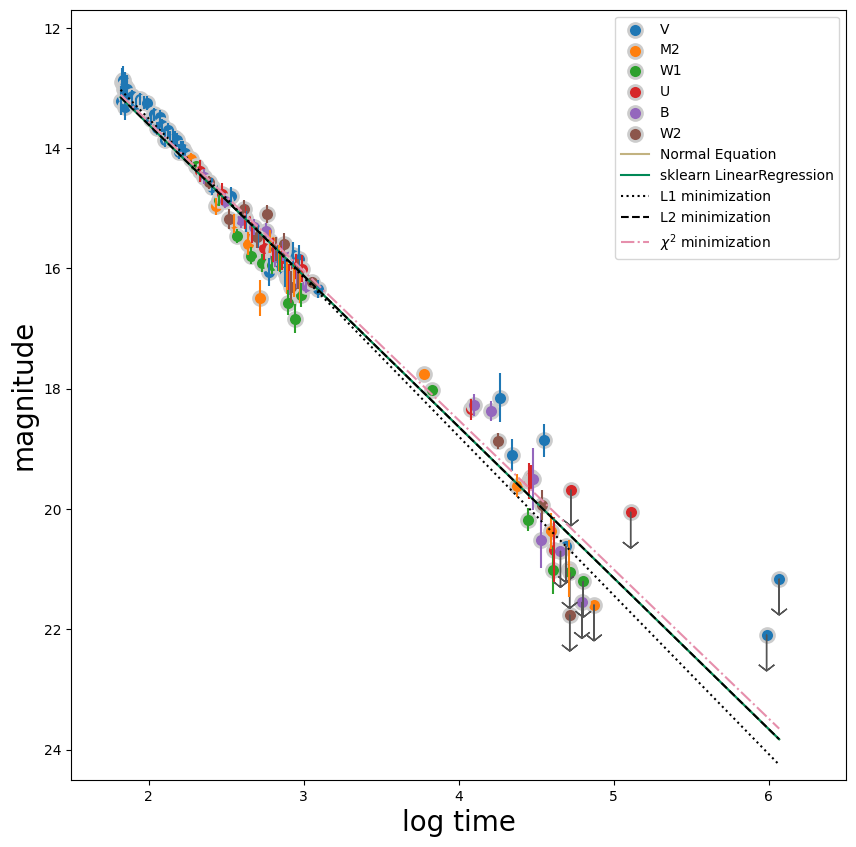

In [73]:
#chatgpt made som changes:
"""
plotline expects (slope, intercept), while most of the instruction's solvers return [intercept, slope],
so I flip those with [::-1].
Also, for sklearn with one feature, the slope is lr.coef_[0] (not [1])
"""



def plotline(pars, x, color='k', symbol='-', label='model', alpha=1, ax=None):
    if ax is None:
        ax = pl.gca()
    slope, intercept = pars
    y = line(intercept, slope, x)   # line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)
    return ax

ax = plotlogtime(grbAG)

# Kelley colors
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C', 'DCD300', '882D17', '8DB600',
          '654522', 'E25822', '2B3D26', '222222', 'F3C300', '875692',
          'F38400', 'A1CAF1', 'BE0032']

# Normal equation (theta_best = [intercept, slope])
plotline((theta_best[1], theta_best[0]), grbAG.logtime.values,
         color='#'+colors[0], label="Normal Equation", ax=ax)

# sklearn (coef_[0] is the slope when there's one feature)
plotline((lr.coef_[0], lr.intercept_), grbAG.logtime.values,
         color='#'+colors[2], symbol='-', label="sklearn LinearRegression", ax=ax)

# minimize L1 (l1Solution.x = [intercept, slope])
plotline((l1Solution.x[1], l1Solution.x[0]), grbAG.logtime.values,
         symbol=':', label="L1 minimization", ax=ax)

# minimize L2 (l2Solution.x = [intercept, slope])
plotline((l2Solution.x[1], l2Solution.x[0]), grbAG.logtime.values,
         symbol='--', label="L2 minimization", ax=ax)

# minimize chi^2 (chi2Solution.x = [intercept, slope])
plotline((chi2Solution.x[1], chi2Solution.x[0]), grbAG.logtime.values,
         color='#'+colors[3], symbol='-.', label=r"$\chi^2$ minimization", ax=ax)

pl.legend()
pl.ylim(24.5, 11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20)


Figure 2: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.

# HW part 2: redo the sklearn model with a train-test split of the data

- choose the train-test rations that you prefer
- get the score for the model when predicting on the train data and on the test data
- what can you say about the model by comparing the two scores?

In [74]:
# --- HW part 2: redo the sklearn model with a train–test split ---

# 1) Keep only real detections (no upper limits)
clean = grbAG.loc[grbAG.upperlimit == 0].copy()

# 2) Features (X) and target (y)
#    X must be 2D for sklearn; we use the double-bracket to get shape (N, 1)
X = clean[["logtime"]]          # predictor = log10(time)
y = clean["mag"].values         # target = magnitude (already log of flux)

# 3) Split into train and test sets
#a common and well-established train/test split is 80/20,
#Training (80%): Enough data for the model to learn meaningful patterns
#Testing (20%): Enough data to get a reliable estimate of generalization performance
#    test_size=0.2 → 80/20 split; random_state fixes the shuffle for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


# 4) Make and fit the linear regression model on the TRAIN set only
lr_split = LinearRegression()
lr_split.fit(X_train, y_train)

# 5) Get the R^2 score on TRAIN and TEST sets (LinearRegression.score defaults to R^2)
r2_train = lr_split.score(X_train, y_train)
r2_test  = lr_split.score(X_test,  y_test)

# 6) Report parameters and scores
slope      = lr_split.coef_[0]     # with one feature, coef_ is length-1
intercept  = lr_split.intercept_
alpha_hat  = slope / 2.5            # physical decay index α = slope / 2.5

print(f"Fit (train set): intercept = {intercept:.2f}, slope = {slope:.2f}, alpha ≈ {alpha_hat:.2f}")
print(f"R^2 (train) = {r2_train:.3f}")
print(f"R^2 (test)  = {r2_test:.3f}")


Fit (train set): intercept = 8.65, slope = 2.49, alpha ≈ 0.99
R^2 (train) = 0.971
R^2 (test)  = 0.972


The high R² scores of 0.971 (training) and 0.972 (testing) demonstrate that a linear model in log-log space explains approximately 97% of the variance in the GRB afterglow photometry. This provides strong statistical evidence that GRB  follows a power-law decay, as the near-perfect alignment between training and test performance confirms the relationship is genuine and not an artifact of overfitting.

Generally:

Train R² ≈ Test R² and both high (e.g., 0.8–0.95): good fit, good generalization.

Train R² ≫ Test R²: overfitting (model fits the training noise and doesn’t generalize well).

Both low (e.g., ≤0.3 or negative test): underfitting or model mis-specification (a straight line isn’t capturing the trend, or features/units need rethinking).

Negative Test R²: the model predicts worse than just using the test-set mean of mag.